In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from numpy import sqrt 
import pickle



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mc90v-full/M2508_train_sensors.csv
/kaggle/input/mc90v-full/M2508_test_sensors.csv
/kaggle/input/mc90v-full/M2508_train_full.csv
/kaggle/input/mc90v-full/M2503_test_full.csv
/kaggle/input/mc90v-full/M2503_train_full.csv
/kaggle/input/mc90v-full/M0000_test_sensors.csv
/kaggle/input/mc90v-full/M2503_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_full.csv
/kaggle/input/mc90v-full/M0000_train_full.csv
/kaggle/input/mc90v-full/M0000_test_full.csv
/kaggle/input/mc90v-full/M2506_train_sensors.csv
/kaggle/input/mc90v-full/M2506_train_full.csv
/kaggle/input/mc90v-full/M2503_test_sensors.csv
/kaggle/input/mc90v-full/M0000_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_sensors.csv
/kaggle/input/mc90v-full/M2508_test_full.csv


In [3]:
m0000_train = pd.read_csv('/kaggle/input/mc90v-full/M0000_train_sensors.csv')
m0000_test = pd.read_csv('/kaggle/input/mc90v-full/M0000_test_sensors.csv')

m2503_train = pd.read_csv('/kaggle/input/mc90v-full/M2503_train_sensors.csv')
m2503_test = pd.read_csv('/kaggle/input/mc90v-full/M2503_test_sensors.csv')

m2506_train = pd.read_csv('/kaggle/input/mc90v-full/M2506_train_sensors.csv')
m2506_test = pd.read_csv('/kaggle/input/mc90v-full/M2506_test_sensors.csv')

m2508_train = pd.read_csv('/kaggle/input/mc90v-full/M2508_train_sensors.csv')
m2508_test = pd.read_csv('/kaggle/input/mc90v-full/M2508_test_sensors.csv')

### Processing

In [1]:
def calculate_RunId_X(df):
    
    if df['Load'] == 0:
        return df['RunId'] * 2 -1
    else:
        return df['RunId'] * 2
    
    
def resample(df):
        df = df.groupby(df.index //4).mean()
        return df
        

def preprocessing(df):
    
    # Getting only SeaTemp = 20 and Windspeed = 0
    df = df[(df.SeaTemp == 'SW20') & (df.WindSpeed == 'WC0')]
    
    # select features
    abr_sensor_list = ['E02005', 'E02006', 'E02056', 'E03760', 'G00027', 'G00108', 'G02011', 'N02015', 'P00023', 'P01005', 'P01302', 'P01303', 'P01600', 'P01602', 'P02055', 'P02065', 'P02066', 'P02071', 'P02072', 'Q02004', 'T00002', 'T01010', 'T01011', 'T01350', 'T01351', 'T01601', 'T01603', 'T02014', 'T02040', 'T02041', 'T02042', 'T02044', 'T04600', 'Z00518', 'Z01970', 'Z02013']
    ic = ['Load','RunId']
    ic.extend(abr_sensor_list)
    df = df[ic]
    
    # LoadType 0-1
    df['Load'] = df['Load'].apply(lambda x: 0 if x == 'FAL' else 1)
    
    # interpolate
    df = df.interpolate().fillna(df.mean())
    
    # create RunID_X column
    runId_column = df.apply(calculate_RunId_X, axis=1)
    df['RunID_X'] = runId_column
    df['RunID_X'] = df['RunID_X'].astype(int)
    
    # resampling
    df = df.groupby('RunID_X').apply(resample)
    
    # drop Load, RunId, RunID_X
    df = df.drop(['Load','RunId', 'RunID_X'], axis =1 )


    return df

In [5]:
def train_test(df_train, df_test):
    
    # X_train - X_test - smokeContent_train - smokeContent_test
    smokeContent_train = df_train['Z02013'] 
    smokeContent_test = df_test['Z02013']

    X_train = df_train.drop(['Z02013'], axis = 1)
    X_test = df_test.drop(['Z02013'], axis = 1)
    
    return X_train, smokeContent_train, X_test, smokeContent_test

In [6]:
def scale_data(X_train, smokeContent_train, X_test, smokeContent_test):
    
    x_train_scaler = MinMaxScaler()
    X_train_scaled = x_train_scaler.fit_transform(X_train)

    x_test_scaler = MinMaxScaler()
    X_test_scaled = x_test_scaler.fit_transform(X_test)

    smokeContent_train_scaler = MinMaxScaler()
    smokeContent_train_scaled = smokeContent_train_scaler.fit_transform(np.array(smokeContent_train).reshape(-1,1))

    smokeContent_test_scaler = MinMaxScaler()
    smokeContent_test_scaled = smokeContent_test_scaler.fit_transform(np.array(smokeContent_test).reshape(-1,1))
    
    return X_train_scaled, smokeContent_train_scaled, X_test_scaled, smokeContent_test_scaled, smokeContent_test_scaler

### Get X_train, smokeContent_train, X_test, smokeContent_test for each Fault Class


In [7]:
# M0000_X_train, M0000_smokeContent_train, M0000_X_test, M000_smokeContent_test

m0000_train = preprocessing(m0000_train)
m0000_test = preprocessing(m0000_test)

M0000_X_train, M0000_smokeContent_train, M0000_X_test, M0000_smokeContent_test = train_test(m0000_train, m0000_test)

M0000_X_train_scaled, M0000_smokeContent_train_scaled, M0000_X_test_scaled, M0000_smokeContent_test_scaled, M0000_smokeContent_test_scaler = scale_data( M0000_X_train, M0000_smokeContent_train, M0000_X_test, M0000_smokeContent_test)
    

# M2503_X_train, M2503_smokeContent_train, M2503_X_test, M2503_smokeContent_test

m2503_train = preprocessing(m2503_train)
m2503_test = preprocessing(m2503_test)

M2503_X_train, M2503_smokeContent_train, M2503_X_test, M2503_smokeContent_test = train_test(m2503_train, m2503_test)

M2503_X_train_scaled, M2503_smokeContent_train_scaled, M2503_X_test_scaled, M2503_smokeContent_test_scaled, M2503_smokeContent_test_scaler = scale_data( M2503_X_train, M2503_smokeContent_train, M2503_X_test, M2503_smokeContent_test)

    
# M2506_X_train, M2506_smokeContent_train, M2506_X_test, M2506_smokeContent_test

m2506_train = preprocessing(m2506_train)
m2506_test = preprocessing(m2506_test)

M2506_X_train, M2506_smokeContent_train, M2506_X_test, M2506_smokeContent_test = train_test(m2506_train, m2506_test)

M2506_X_train_scaled, M2506_smokeContent_train_scaled, M2506_X_test_scaled, M2506_smokeContent_test_scaled, M2506_smokeContent_test_scaler = scale_data( M2506_X_train, M2506_smokeContent_train, M2506_X_test, M2506_smokeContent_test)


# M2508_X_train, M2508_smokeContent_train, M2508_X_test, M2508_smokeContent_test

m2508_train = preprocessing(m2508_train)
m2508_test = preprocessing(m2508_test)

M2508_X_train, M2508_smokeContent_train, M2508_X_test, M2508_smokeContent_test = train_test(m2508_train, m2508_test)

M2508_X_train_scaled, M2508_smokeContent_train_scaled, M2508_X_test_scaled, M2508_smokeContent_test_scaled, M2508_smokeContent_test_scaler = scale_data( M2508_X_train, M2508_smokeContent_train, M2508_X_test, M2508_smokeContent_test)

### M0000 - GPR Model

In [8]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr_m0000 = GaussianProcessRegressor(kernel=kernel, alpha=0.1, random_state = 42)

gpr_m0000.fit(M0000_X_train_scaled, M0000_smokeContent_train_scaled)

m0000_filename = 'm0000_model.pkl'
pickle.dump(gpr_m0000, open(m0000_filename, 'wb'))

/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


### M2503 - GPR Model


In [9]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr_m2503 = GaussianProcessRegressor(kernel=kernel, alpha=0.1, random_state = 42)

gpr_m2503.fit(M2503_X_train_scaled, M2503_smokeContent_train_scaled)

m2503_filename = 'm2503_model.pkl'
pickle.dump(gpr_m2503, open(m2503_filename, 'wb'))

### M2506 - GPR Model


In [10]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr_m2506 = GaussianProcessRegressor(kernel=kernel, alpha=0.1, random_state = 42)

gpr_m2506.fit(M2506_X_train_scaled, M2506_smokeContent_train_scaled)

m2506_filename = 'm2506_model.pkl'
pickle.dump(gpr_m2506, open(m2506_filename, 'wb'))

### M2508 - GPR Model

In [11]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr_m2508 = GaussianProcessRegressor(kernel=kernel, alpha=0.1, random_state = 42)

gpr_m2508.fit(M2508_X_train_scaled, M2508_smokeContent_train_scaled)

m2508_filename = 'm2508_model.pkl'
pickle.dump(gpr_m2508, open(m2508_filename, 'wb'))

### Predictions

In [12]:
def predict_smokeContent(X_test_scaled, smokeContent_test_scaler, gpr):
    
    smokeContent_pred_scaled = gpr.predict(X_test_scaled, return_std=False)
    smokeContent_pred_scaled = smokeContent_pred_scaled.flatten()
    smokeContent_pred_scaled = smokeContent_pred_scaled.reshape(-1, 1)
    smokeContent_pred = smokeContent_test_scaler.inverse_transform(smokeContent_pred_scaled)
    
    return smokeContent_pred

In [ ]:
# predict with M0000 model
M0000_smokeContent_pred_model_M0000 = predict_smokeContent(M0000_X_test_scaled, M0000_smokeContent_test_scaler, gpr_m0000)
M2503_smokeContent_pred_model_M0000 = predict_smokeContent(M2503_X_test_scaled, M2503_smokeContent_test_scaler, gpr_m0000)
M2506_smokeContent_pred_model_M0000 = predict_smokeContent(M2506_X_test_scaled, M2506_smokeContent_test_scaler, gpr_m0000)
M2508_smokeContent_pred_model_M0000 = predict_smokeContent(M2508_X_test_scaled, M2508_smokeContent_test_scaler, gpr_m0000)

# predict with M2503 model
M0000_smokeContent_pred_model_M2503 = predict_smokeContent(M0000_X_test_scaled, M0000_smokeContent_test_scaler, gpr_m2503)
M2503_smokeContent_pred_model_M2503 = predict_smokeContent(M2503_X_test_scaled, M2503_smokeContent_test_scaler, gpr_m2503)
M2506_smokeContent_pred_model_M2503 = predict_smokeContent(M2506_X_test_scaled, M2506_smokeContent_test_scaler, gpr_m2503)
M2508_smokeContent_pred_model_M2503 = predict_smokeContent(M2508_X_test_scaled, M2508_smokeContent_test_scaler, gpr_m2503)

# predict with M2506 model
M0000_smokeContent_pred_model_M2506 = predict_smokeContent(M0000_X_test_scaled, M0000_smokeContent_test_scaler, gpr_m2506)
M2503_smokeContent_pred_model_M2506 = predict_smokeContent(M2503_X_test_scaled, M2503_smokeContent_test_scaler, gpr_m2506)
M2506_smokeContent_pred_model_M2506 = predict_smokeContent(M2506_X_test_scaled, M2506_smokeContent_test_scaler, gpr_m2506)
M2508_smokeContent_pred_model_M2506 = predict_smokeContent(M2508_X_test_scaled, M2508_smokeContent_test_scaler, gpr_m2506)

# predict with M2508 model
M0000_smokeContent_pred_model_M2508 = predict_smokeContent(M0000_X_test_scaled, M0000_smokeContent_test_scaler, gpr_m2508)
M2503_smokeContent_pred_model_M2508 = predict_smokeContent(M2503_X_test_scaled, M2503_smokeContent_test_scaler, gpr_m2508)
M2506_smokeContent_pred_model_M2508 = predict_smokeContent(M2506_X_test_scaled, M2506_smokeContent_test_scaler, gpr_m2508)
M2508_smokeContent_pred_model_M2508 = predict_smokeContent(M2508_X_test_scaled, M2508_smokeContent_test_scaler, gpr_m2508)

### RMSE

In [14]:
print("RMSE | M0000 Model")

M0000_rmse_m0000 = sqrt(mean_squared_error(M0000_smokeContent_test, M0000_smokeContent_pred_model_M0000))
print("M0000 Normal: ", M0000_rmse_m0000)

M2503_rmse_m0000 = sqrt(mean_squared_error(M2503_smokeContent_test, M2503_smokeContent_pred_model_M0000))
print("M2503 Fault: ", M2503_rmse_m0000)

M2506_rmse_m0000 = sqrt(mean_squared_error(M2506_smokeContent_test, M2506_smokeContent_pred_model_M0000))
print("M2506 Fault: ", M2506_rmse_m0000)

M2508_rmse_m0000 = sqrt(mean_squared_error(M2508_smokeContent_test, M2508_smokeContent_pred_model_M0000))
print("M2508 Fault: ", M2508_rmse_m0000)

print("-----------------------------")

print("RMSE | M2503 Model")

M0000_rmse_m2503 = sqrt(mean_squared_error(M0000_smokeContent_test, M0000_smokeContent_pred_model_M2503))
print("M0000 Normal: ", M0000_rmse_m2503)

M2503_rmse_m2503 = sqrt(mean_squared_error(M2503_smokeContent_test, M2503_smokeContent_pred_model_M2503))
print("M2503 Fault: ", M2503_rmse_m2503)

M2506_rmse_m2503 = sqrt(mean_squared_error(M2506_smokeContent_test, M2506_smokeContent_pred_model_M2503))
print("M2506 Fault: ", M2506_rmse_m2503)

M2508_rmse_m2503 = sqrt(mean_squared_error(M2508_smokeContent_test, M2508_smokeContent_pred_model_M2503))
print("M2508 Fault: ", M2508_rmse_m2503)

print("-----------------------------")

print("RMSE | M2506 Model")

M0000_rmse_m2506 = sqrt(mean_squared_error(M0000_smokeContent_test, M0000_smokeContent_pred_model_M2506))
print("M0000 Normal: ", M0000_rmse_m2506)

M2503_rmse_m2506 = sqrt(mean_squared_error(M2503_smokeContent_test, M2503_smokeContent_pred_model_M2506))
print("M2503 Fault: ", M2503_rmse_m2506)

M2506_rmse_m2506 = sqrt(mean_squared_error(M2506_smokeContent_test, M2506_smokeContent_pred_model_M2506))
print("M2506 Fault: ", M2506_rmse_m2506)

M2508_rmse_m2506 = sqrt(mean_squared_error(M2508_smokeContent_test, M2508_smokeContent_pred_model_M2506))
print("M2508 Fault: ", M2508_rmse_m2506)

print("-----------------------------")

print("RMSE | M2508 Model")

M0000_rmse_m2508 = sqrt(mean_squared_error(M0000_smokeContent_test, M0000_smokeContent_pred_model_M2508))
print("M0000 Normal: ", M0000_rmse_m2508)

M2503_rmse_m2508 = sqrt(mean_squared_error(M2503_smokeContent_test, M2503_smokeContent_pred_model_M2508))
print("M2503 Fault: ", M2503_rmse_m2508)

M2506_rmse_m2508 = sqrt(mean_squared_error(M2506_smokeContent_test, M2506_smokeContent_pred_model_M2508))
print("M2506 Fault: ", M2506_rmse_m2508)

M2508_rmse_m2508 = sqrt(mean_squared_error(M2508_smokeContent_test, M2508_smokeContent_pred_model_M2508))
print("M2508 Fault: ", M2508_rmse_m2508)

RMSE | M0000 Model
M0000 Normal:  0.037521797389231636
M2503 Fault:  3.0886472231436746
M2506 Fault:  6.792741335672674
M2508 Fault:  6.581306214521013
-----------------------------
RMSE | M2503 Model
M0000 Normal:  0.5214616249768992
M2503 Fault:  0.09974294859846022
M2506 Fault:  10.7326875404387
M2508 Fault:  7.933821996400064
-----------------------------
RMSE | M2506 Model
M0000 Normal:  0.11570593845068973
M2503 Fault:  2.08538391739038
M2506 Fault:  3.2731446893278453
M2508 Fault:  2.1390526455013745
-----------------------------
RMSE | M2508 Model
M0000 Normal:  0.1893970679412852
M2503 Fault:  2.2124868330326777
M2506 Fault:  2.1560511065778156
M2508 Fault:  1.517723358793741


In [26]:
# M0000_X_test['Z02013'] = M0000_smokeContent_test
M0000_X_test['Z02013'] = M0000_smokeContent_test
M0000_X_test['pred_m0000'] = M0000_smokeContent_pred_model_M0000 
M0000_X_test['pred_m2503'] = M0000_smokeContent_pred_model_M2503 
M0000_X_test['pred_m2506'] = M0000_smokeContent_pred_model_M2506 
M0000_X_test['pred_m2508'] = M0000_smokeContent_pred_model_M2508

M2503_X_test['Z02013'] = M2503_smokeContent_test
M2503_X_test['pred_m0000'] = M2503_smokeContent_pred_model_M0000 
M2503_X_test['pred_m2503'] = M2503_smokeContent_pred_model_M2503 
M2503_X_test['pred_m2506'] = M2503_smokeContent_pred_model_M2506 
M2503_X_test['pred_m2508'] = M2503_smokeContent_pred_model_M2508

M2506_X_test['Z02013'] = M2506_smokeContent_test
M2506_X_test['pred_m0000'] = M2506_smokeContent_pred_model_M0000 
M2506_X_test['pred_m2503'] = M2506_smokeContent_pred_model_M2503 
M2506_X_test['pred_m2506'] = M2506_smokeContent_pred_model_M2506 
M2506_X_test['pred_m2508'] = M2506_smokeContent_pred_model_M2508

M2508_X_test['Z02013'] = M2508_smokeContent_test
M2508_X_test['pred_m0000'] = M2508_smokeContent_pred_model_M0000 
M2508_X_test['pred_m2503'] = M2508_smokeContent_pred_model_M2503 
M2508_X_test['pred_m2506'] = M2508_smokeContent_pred_model_M2506 
M2508_X_test['pred_m2508'] = M2508_smokeContent_pred_model_M2508
 

### Visualization

#### Plotting by model

In [35]:
def model_plot_m0000(runid, M0000_X_test, M2503_X_test, M2506_X_test, M2508_X_test, load_type):
    
    #36
    runid_x = runid * 2 -1
    
    if load_type == "FAL":
    
        smokeContent_fal = M0000_X_test.loc[runid_x]['Z02013']  # 0
        m0000_pred_fal = M0000_X_test.loc[runid_x]['pred_m0000']
        m2503_pred_fal = M2503_X_test.loc[runid_x]['pred_m0000']
        m2506_pred_fal = M2506_X_test.loc[runid_x]['pred_m0000']
        m2508_pred_fal = M2508_X_test.loc[runid_x]['pred_m0000']
        
        plt.plot(smokeContent_fal.values,label="m0000_FAL_test", color="red")  
        plt.plot(m0000_pred_fal.values ,label="m0000_FAL_pred", color="blue")
        plt.plot(m2503_pred_fal.values ,label="m2503_FAL_pred", color="green")
        plt.plot(m2506_pred_fal.values ,label="m2506_FAL_pred", color="pink")
        plt.plot(m2508_pred_fal.values ,label="m2508_FAL_pred", color="yellow")
        
        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = "M0000 Model - Smoke Content Predictions  |  "  +  "  RunId:" + str(runid) + "  | FAL"
        plt.title(title_)
        plt.show()
        
    elif load_type == "FAU":
    
    
        smokeContent_fau = M0000_X_test.loc[runid_x + 1]['Z02013']  # 1
        m0000_pred_fau = M0000_X_test.loc[runid_x + 1]['pred_m0000']
        m2503_pred_fau = M2503_X_test.loc[runid_x + 1]['pred_m0000']
        m2506_pred_fau = M2506_X_test.loc[runid_x + 1]['pred_m0000']
        m2508_pred_fau = M2508_X_test.loc[runid_x + 1]['pred_m0000']

        plt.plot(smokeContent_fau.values,label="m0000_FAU_test", color="red")  
        plt.plot(m0000_pred_fau.values ,label="m0000_FAU_pred", color="blue")
        plt.plot(m2503_pred_fau.values ,label="m2503_FAU_pred", color="green")
        plt.plot(m2506_pred_fau.values ,label="m2506_FAU_pred", color="pink")
        plt.plot(m2508_pred_fau.values ,label="m2508_FAU_pred", color="yellow")

        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = "M0000 Model - Smoke Content Predictions  |  "  +  "  RunId:" + str(runid) + "  | FAU"
        plt.title(title_)
        plt.show()


In [36]:
def model_plot_m2503(runid, M0000_X_test, M2503_X_test, M2506_X_test, M2508_X_test, load_type):
    
    #36
    runid_x = runid * 2 -1
    
    if load_type == "FAL":
    
        smokeContent_fal = M2503_X_test.loc[runid_x]['Z02013']  # 0
        m0000_pred_fal = M0000_X_test.loc[runid_x]['pred_m2503']
        m2503_pred_fal = M2503_X_test.loc[runid_x]['pred_m2503']
        m2506_pred_fal = M2506_X_test.loc[runid_x]['pred_m2503']
        m2508_pred_fal = M2508_X_test.loc[runid_x]['pred_m2503']
        
        plt.plot(smokeContent_fal.values,label="m2503_FAL_test", color="red")  
        plt.plot(m0000_pred_fal.values ,label="m0000_FAL_pred", color="blue")
        plt.plot(m2503_pred_fal.values ,label="m2503_FAL_pred", color="green")
        plt.plot(m2506_pred_fal.values ,label="m2506_FAL_pred", color="pink")
        plt.plot(m2508_pred_fal.values ,label="m2508_FAL_pred", color="yellow")
        
        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = "M2503 Model - Smoke Content Predictions  |  " +  "  RunId:" +  str(runid) + "  | FAL"
        plt.title(title_)
        plt.show()
        
    elif load_type == "FAU":
    
    
        smokeContent_fau = M2503_X_test.loc[runid_x + 1]['Z02013']  # 1
        m0000_pred_fau = M0000_X_test.loc[runid_x + 1]['pred_m2503']
        m2503_pred_fau = M2503_X_test.loc[runid_x + 1]['pred_m2503']
        m2506_pred_fau = M2506_X_test.loc[runid_x + 1]['pred_m2503']
        m2508_pred_fau = M2508_X_test.loc[runid_x + 1]['pred_m2503']

        plt.plot(smokeContent_fau.values,label="m2503_FAU_test", color="red")  
        plt.plot(m0000_pred_fau.values ,label="m0000_FAU_pred", color="blue")
        plt.plot(m2503_pred_fau.values ,label="m2503_FAU_pred", color="green")
        plt.plot(m2506_pred_fau.values ,label="m2506_FAU_pred", color="pink")
        plt.plot(m2508_pred_fau.values ,label="m2508_FAU_pred", color="yellow")

        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = "M2503 Model - Smoke Content Predictions  |  "  +  "  RunId:" + str(runid) + "  | FAU"
        plt.title(title_)
        plt.show()

In [37]:
def model_plot_m2506(runid, M0000_X_test, M2503_X_test, M2506_X_test, M2508_X_test, load_type):
    
    #36
    runid_x = runid * 2 -1
    
    if load_type == "FAL":
    
        smokeContent_fal = M2506_X_test.loc[runid_x]['Z02013']  # 0
        m0000_pred_fal = M0000_X_test.loc[runid_x]['pred_m2506']
        m2503_pred_fal = M2503_X_test.loc[runid_x]['pred_m2506']
        m2506_pred_fal = M2506_X_test.loc[runid_x]['pred_m2506']
        m2508_pred_fal = M2508_X_test.loc[runid_x]['pred_m2506']
        
        plt.plot(smokeContent_fal.values,label="m2506_FAL_test", color="red")  
        plt.plot(m0000_pred_fal.values ,label="m0000_FAL_pred", color="blue")
        plt.plot(m2503_pred_fal.values ,label="m2503_FAL_pred", color="green")
        plt.plot(m2506_pred_fal.values ,label="m2506_FAL_pred", color="pink")
        plt.plot(m2508_pred_fal.values ,label="m2508_FAL_pred", color="yellow")
        
        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = "M2506 Model - Smoke Content Predictions  |  "  +  "  RunId:" + str(runid) + "  | FAL"
        plt.title(title_)
        plt.show()
        
    elif load_type == "FAU":
    
    
        smokeContent_fau = M2506_X_test.loc[runid_x + 1]['Z02013']  # 1
        m0000_pred_fau = M0000_X_test.loc[runid_x + 1]['pred_m2506']
        m2503_pred_fau = M2503_X_test.loc[runid_x + 1]['pred_m2506']
        m2506_pred_fau = M2506_X_test.loc[runid_x + 1]['pred_m2506']
        m2508_pred_fau = M2508_X_test.loc[runid_x + 1]['pred_m2506']

        plt.plot(smokeContent_fau.values,label="m2506_FAU_test", color="red")  
        plt.plot(m0000_pred_fau.values ,label="m0000_FAU_pred", color="blue")
        plt.plot(m2503_pred_fau.values ,label="m2503_FAU_pred", color="green")
        plt.plot(m2506_pred_fau.values ,label="m2506_FAU_pred", color="pink")
        plt.plot(m2508_pred_fau.values ,label="m2508_FAU_pred", color="yellow")

        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = "M2506 Model - Smoke Content Predictions  |  "  +  "  RunId:" +  str(runid) + "  | FAU"
        plt.title(title_)
        plt.show()

In [38]:
def model_plot_m2508(runid, M0000_X_test, M2503_X_test, M2506_X_test, M2508_X_test, load_type):
    
    #36
    runid_x = runid * 2 -1
    
    if load_type == "FAL":
    
        smokeContent_fal = M2508_X_test.loc[runid_x]['Z02013']  # 0
        m0000_pred_fal = M0000_X_test.loc[runid_x]['pred_m2508']
        m2503_pred_fal = M2503_X_test.loc[runid_x]['pred_m2508']
        m2506_pred_fal = M2506_X_test.loc[runid_x]['pred_m2508']
        m2508_pred_fal = M2508_X_test.loc[runid_x]['pred_m2508']
        
        plt.plot(smokeContent_fal.values,label="m2508_FAL_test", color="red")  
        plt.plot(m0000_pred_fal.values ,label="m0000_FAL_pred", color="blue")
        plt.plot(m2503_pred_fal.values ,label="m2503_FAL_pred", color="green")
        plt.plot(m2506_pred_fal.values ,label="m2506_FAL_pred", color="pink")
        plt.plot(m2508_pred_fal.values ,label="m2508_FAL_pred", color="yellow")
        
        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = "M2508 Model - Smoke Content Predictions  |  "  +  "  RunId:" + str(runid) + "  | FAL"
        plt.title(title_)
        plt.show()
        
    elif load_type == "FAU":
    
    
        smokeContent_fau = M2508_X_test.loc[runid_x + 1]['Z02013']  # 1
        m0000_pred_fau = M0000_X_test.loc[runid_x + 1]['pred_m2508']
        m2503_pred_fau = M2503_X_test.loc[runid_x + 1]['pred_m2508']
        m2506_pred_fau = M2506_X_test.loc[runid_x + 1]['pred_m2508']
        m2508_pred_fau = M2508_X_test.loc[runid_x + 1]['pred_m2508']

        plt.plot(smokeContent_fau.values,label="m2508_FAU_test", color="red")  
        plt.plot(m0000_pred_fau.values ,label="m0000_FAU_pred", color="blue")
        plt.plot(m2503_pred_fau.values ,label="m2503_FAU_pred", color="green")
        plt.plot(m2506_pred_fau.values ,label="m2506_FAU_pred", color="pink")
        plt.plot(m2508_pred_fau.values ,label="m2508_FAU_pred", color="yellow")

        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = "M2508 Model - Smoke Content Predictions  |  "  +  "  RunId:" + str(runid) + "  | FAU"
        plt.title(title_)
        plt.show()

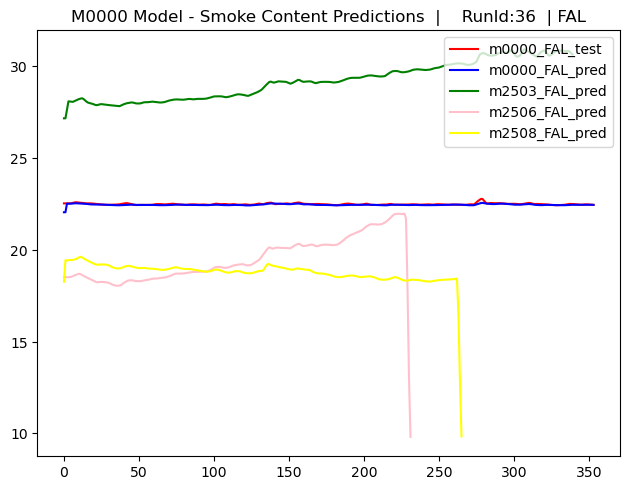

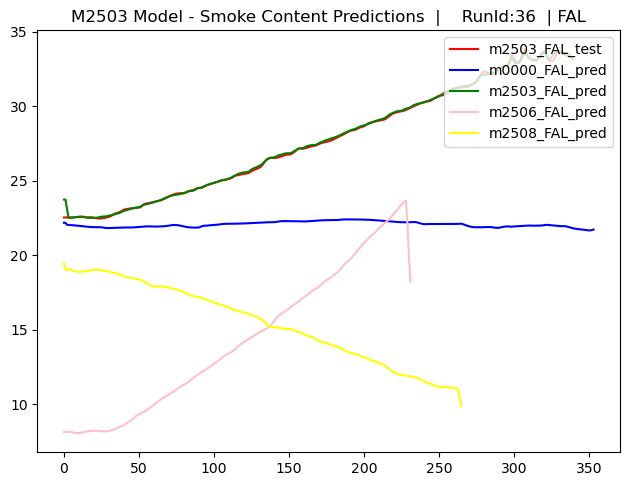

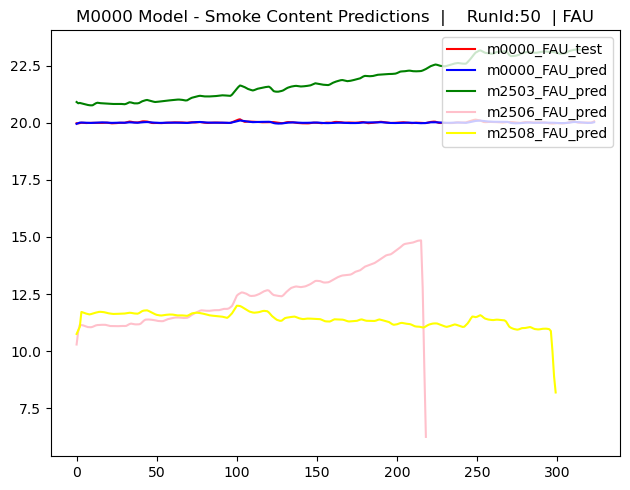

In [39]:
# M0000 Model |  RunId : 36  |  FAL
model_plot_m0000(36, M0000_X_test, M2503_X_test, M2506_X_test, M2508_X_test, "FAL")


# M2503 Model |  RunId : 36  |  FAL
model_plot_m2503(36, M0000_X_test, M2503_X_test, M2506_X_test, M2508_X_test, "FAL")

# M0000 Model |  RunId : 50  |  FAU
model_plot_m0000(50, M0000_X_test, M2503_X_test, M2506_X_test, M2508_X_test, "FAU")

#### Plotting by Fault Class

In [32]:
def fault_class_plot(runid, X_test, fault_class, load_type):
    
    
    runid_x = runid * 2 -1
    
    if load_type == "FAL":
    
        smokeContent_fal = X_test.loc[runid_x]['Z02013']
        pred_m0000_model_fal = X_test.loc[runid_x]['pred_m0000']
        pred_m2503_model_fal = X_test.loc[runid_x]['pred_m2503']
        pred_m2506_model_fal = X_test.loc[runid_x]['pred_m2506']
        pred_m2508_model_fal = X_test.loc[runid_x]['pred_m2508']
        
        label_ = ""
        label_ += fault_class + "_FAL_test"
        

        plt.plot(smokeContent_fal.values,label = label_ , color="red")  
        plt.plot(pred_m0000_model_fal.values ,label="m0000_model_FAL_pred", color="blue")
        plt.plot(pred_m2503_model_fal.values ,label="m2503_model_FAL_pred", color="green")
        plt.plot(pred_m2506_model_fal.values ,label="m2506_model_FAL_pred", color="pink")
        plt.plot(pred_m2508_model_fal.values ,label="m2508_model_FAL_pred", color="yellow")
        
        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = fault_class + " Dataset - Smoke Content Predictions  |  "  +  "  RunId:" + str(runid) + "  | FAL"
        plt.title(title_)
        plt.show()
        
    elif load_type == "FAU":
        
    
        smokeContent_fau = X_test.loc[runid_x + 1]['Z02013']
        pred_m0000_model_fau = X_test.loc[runid_x + 1]['pred_m0000']
        pred_m2503_model_fau = X_test.loc[runid_x + 1]['pred_m2503']
        pred_m2506_model_fau = X_test.loc[runid_x + 1]['pred_m2506']
        pred_m2508_model_fau = X_test.loc[runid_x + 1]['pred_m2508']

        label_ = ""
        label_ += fault_class + "_FAU_test"
        

        plt.plot(smokeContent_fau.values,label = label_ , color="red")  
        plt.plot(pred_m0000_model_fau.values ,label="m0000_model_FAU_pred", color="blue")
        plt.plot(pred_m2503_model_fau.values ,label="m2503_model_FAU_pred", color="green")
        plt.plot(pred_m2506_model_fau.values ,label="m2506_model_FAU_pred", color="pink")
        plt.plot(pred_m2508_model_fau.values ,label="m2508_model_FAU_pred", color="yellow")
        
        plt.legend(loc="upper right")

        plt.tight_layout()
        title_ = fault_class + " Dataset - Smoke Content Predictions  |  "  +  "  RunId:" + str(runid) + "  | FAU"
        plt.title(title_)
        plt.show()

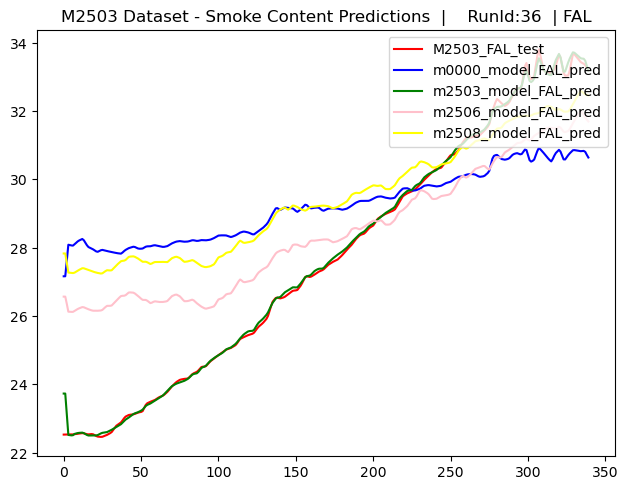

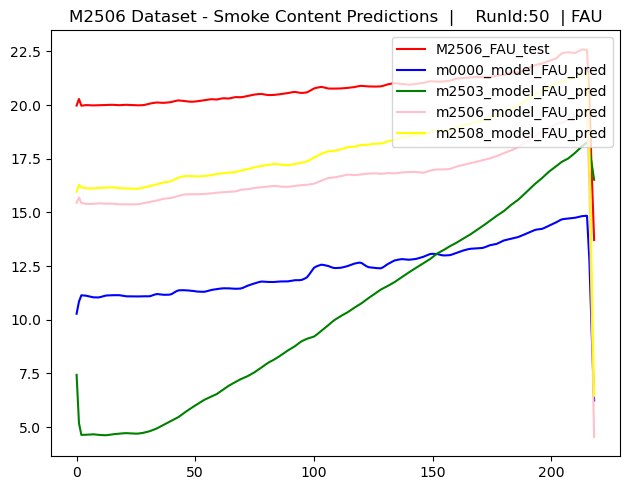

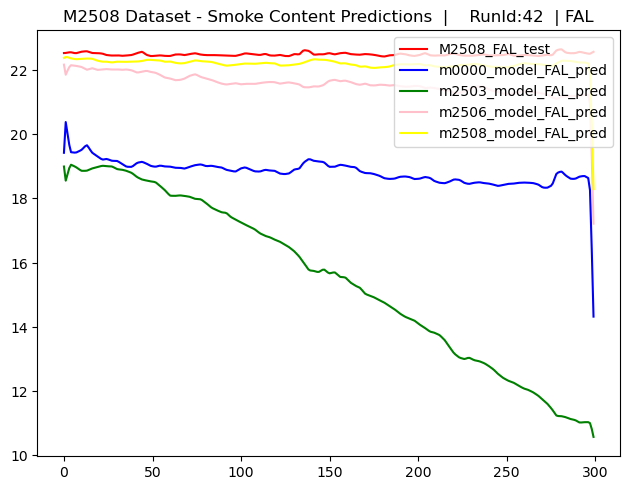

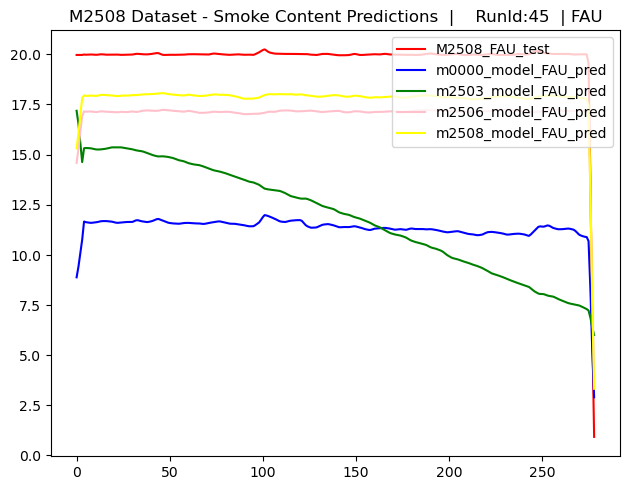

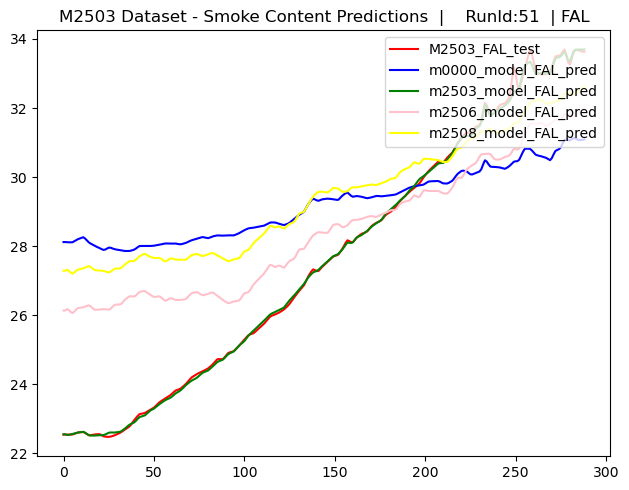

In [49]:
# Fault Class = M2503  |  RunId: 36  |  FAL
fault_class_plot(36, M2503_X_test, "M2503", "FAL")

# Fault Class = M2506  |  RunId: 50  |  FAU
fault_class_plot(50, M2506_X_test, "M2506", "FAU")

# Fault Class = M2508  |  RunId: 42  |  FAL
fault_class_plot(42, M2508_X_test, "M2508", "FAL")

# Fault Class = M2508  |  RunId: 45  |  FAU
fault_class_plot(45, M2508_X_test, "M2508", "FAU")

# Fault Class = M2503  |  RunId: 51  |  FAL
fault_class_plot(51, M2503_X_test, "M2503", "FAL")